In [100]:
#single_image = r"C:\Users\danie\Desktop\tiny rainbow.jpg"
image_folder = r"C:\Users\midyr\Downloads\colorwheels"
image_pathway = r"C:\Users\midyr\Downloads\traffic4.jpg"

TOO_SMALL = 20
SMALL = 500000
MEDIUM = 1200000
LARGE = 2100000
    
X_train = []
Y_train = []
counter = 1
    
height = 256
width = 256

total_images = 1

In [101]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage
import glob
import cv2
import pandas as pd
from tensorflow.keras import callbacks
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, UpSampling2D, InputLayer, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage import data, io, color
from skimage.io import imread, imshow, imsave
from pathlib import Path

from sklearn.decomposition import PCA

import matplotlib as mpl
import matplotlib.pyplot as plt

In [102]:
def shape(img):
    size = 0
    resolution = img.shape[0] * img.shape[1]
    if resolution <= TOO_SMALL:
        size = 0
    elif resolution <= SMALL:
        size = 1
    elif resolution <= MEDIUM:
        size = 2
    elif resolution <= LARGE:
        size = 3
    else:
        size = 6
    return size

In [103]:
def create_dataframe(image_folder):
    images = Path(image_folder).glob('*.jpg') #.png

    list_of_files = []
    for image in images:
        list_of_files.append(str(image))

    df = pd. DataFrame(list_of_files, columns = ["image_path"])
    df_length = len(df.index)
    
    print("processing", df_length, "photos for training")
    
    height_list= []
    width_list = []
    resolution = []
    
    for image_path in df['image_path']:
        img = cv2.imread(str(image_path))
        height_list.append(img.shape[0])
        width_list.append(img.shape[1])
        
    df["height"] = height_list
    df["width"] = width_list
    df["resolution"] = df["height"] * df["width"]
    
    df = df[df.resolution < LARGE]
    
    ll = df_length - len(df.index)
    print("dropped ", ll, "photos because they were too large to process")
    
    df = df[df.resolution > TOO_SMALL]
    
    ss = df_length - len(df.index) - ll
    print("dropped ", ss, "photos because they were too small to process")
    df.head()
    
    return df

In [104]:
def pca_rgb(imgBGR, size): #imgRGB, size
    b,g,r = cv2.split(imgBGR)
    list_channels = [b,g,r]
    
    #check size first
    if size ==1:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 100)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)    

    elif size == 2:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 300)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)
    else:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 500)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)
        
    RGB_compressed = np.float32(RGB_compressed)
    print("PCA SHAPE",np.min(RGB_compressed),np.max(RGB_compressed))    
    return RGB_compressed

In [105]:
def rgb_pad(image):
    
    img_height = image.shape[0]
    print(height)
    img_width = image.shape[1]
    print(width)
    
    WHITE = [255,255,255] #[255,255,255]  1, 1, 1
    
    if img_height % 2 == 0:
        top = int((height - img_height)/ 2)
        bottom = int((height - img_height)/ 2)
    else: 
        top = int((height - (img_height-1))/ 2)
        bottom = int(((height - (img_height-1))/ 2)-1)

    if img_width % 2 == 0:
        left = int((width - img_width)/ 2)
        right = int((width - img_width)/ 2)
    else: 
        left = int((width - (img_width-1))/ 2)
        right = int(((width - (img_width-1))/2)-1)
    
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT,value=WHITE)
    print(image.shape)
    print(np.min(image),np.max(image))

    return image

In [106]:
def prep_img(img_path):
    imgRGB = img_to_array(load_img(img_path))
    imgRGB = np.array(imgRGB, dtype=float)
    print('Padded:', np.min(imgRGB), np.max(imgRGB))



    image_size_category = shape(imgRGB) 
    if image_size_category <1:
        raise Exception("Your image is too small to be used")
    elif image_size_category >4:
        raise Exception("Your image is too big to be used")

    if PCA_YN == "yes":
        RGB_compressed = pca_rgb(imgRGB, image_size_category)
        RGB_compressed = np.clip(RGB_compressed,0,1) * 255
        print("PCA ran")
    else:
        RGB_compressed = imgRGB
        print("PCA did not run")


    
    padded_image = rgb_pad(RGB_compressed)

    print('Padded:', np.min(padded_image), np.max(padded_image))
    X_LAB = color.rgb2lab(1.0/255*padded_image)[:,:,0] #1.0/255*padded_image
    print('X_LAB:', np.min(X_LAB), np.max(X_LAB))
    Y_LAB1 = color.rgb2lab(1.0/255*padded_image)[:,:,1:] #1.0/255*padded_image
    print('Y_LAB_org:', np.min(Y_LAB1), np.max(Y_LAB1))
    #Y_LAB = Y_LAB1 / 128
    Y_LAB = (Y_LAB1 + 128)/ 256
    print('Y_LAB:', np.min(Y_LAB), np.max(Y_LAB))


    print(X_LAB.shape)
    X = X_LAB.reshape(1, height, width, 1) #comment out when show predicted
    Y = Y_LAB.reshape(1, height, width, 2) #comment out when show predicted
    
    print("image processed")

    return Y, X 

In [107]:
def prep_dataframe(df):
    for index, row in df.iterrows():
        Y, X = prep_img(row["image_path"])
        Y_train.append(Y)
        X_train.append(X)

In [108]:
PCA_YN = "no"

#prep_image(single_image)

df = create_dataframe(image_folder)
prep_dataframe(df)

processing 4 photos for training
dropped  0 photos because they were too large to process
dropped  0 photos because they were too small to process
Padded: 0.0 255.0
PCA did not run
256
256
(256, 256, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 0.17702971378012577 100.0
Y_LAB_org: -71.17268893328688 77.75729265802376
Y_LAB: 0.22198168385434813 0.8037394244454052
(256, 256)
image processed
Padded: 0.0 255.0
PCA did not run
256
256
(256, 256, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 0.039573654069084085 100.0
Y_LAB_org: -90.63866915032773 83.20574458892847
Y_LAB: 0.1459426986315323 0.8250224398005018
(256, 256)
image processed
Padded: 0.0 255.0
PCA did not run
256
256
(256, 256, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 0.8013688253736433 100.0
Y_LAB_org: -48.95291303408261 90.26595316207187
Y_LAB: 0.3087776834606148 0.8526013795393432
(256, 256)
image processed
Padded: 0.0 255.0
PCA did not run
256
256
(256, 256, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 0.4324681123001284 99.45842141301871
Y_LAB_org: -3

# MODEL

In [109]:
BATCH_SIZE = 3
LEARNING_RATE = 0.001 #0.001
EPOCHS = 1000 #500
KERNEL_SIZE = 2 
NUM_CLASSES = 64 #64
#IMAGE_WIDTH = 128 #128
#IMAGE_HEIGHT = 128 #128
#SIGMA = 5

#early_stopping_cb = callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

In [110]:
def mode():
   
    model = tf.keras.Sequential([
    Conv2D(64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(64, kernel_size=KERNEL_SIZE, activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),

    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),

    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),

    Conv2D(512, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(512, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(512, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    BatchNormalization(),

    Conv2D(512, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    Conv2D(512, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    Conv2D(512, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    BatchNormalization(),

    Conv2D(512, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    Conv2D(512, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    Conv2D(512, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    BatchNormalization(),

    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    BatchNormalization(),

    UpSampling2D(size=(2, 2)),
    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    BatchNormalization(),

    Conv2D(NUM_CLASSES, kernel_size=KERNEL_SIZE, padding='same'),
    UpSampling2D(size=(2, 2)),
    
    Conv2D(16, kernel_size=KERNEL_SIZE, padding='same'),    
        
    Conv2D(2, kernel_size=KERNEL_SIZE, padding='same'),
    UpSampling2D(size=(2, 2))])
    
    model.compile(optimizer ="rmsprop", loss = "mse", metrics = ["accuracy"])
    
    return model 

#?? Acitivation function and Loss function #CategoricalCrossentropy
#Conv2D(NUM_CLASSES, kernel_size=1, padding='same', activation='softmax'), UpSampling2D(size=(4, 4))])

In [111]:
model = mode()

In [112]:
model.build((1,256,256,1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_122 (Conv2D)         (1, 256, 256, 64)         320       
                                                                 
 conv2d_123 (Conv2D)         (1, 128, 128, 64)         16448     
                                                                 
 batch_normalization_40 (Bat  (1, 128, 128, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_124 (Conv2D)         (1, 128, 128, 128)        32896     
                                                                 
 conv2d_125 (Conv2D)         (1, 64, 64, 128)          65664     
                                                                 
 batch_normalization_41 (Bat  (1, 64, 64, 128)         512       
 chNormalization)                                     

In [113]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

In [114]:
len(X_train)

4

In [115]:
%%time
history = model.fit(train_data, batch_size = BATCH_SIZE, epochs = EPOCHS, verbose = 2)  # add validation_split = 0.2

Epoch 1/1000
4/4 - 4s - loss: 6.4749 - accuracy: 0.5096 - 4s/epoch - 918ms/step
Epoch 2/1000
4/4 - 2s - loss: 2.3576 - accuracy: 0.4626 - 2s/epoch - 456ms/step
Epoch 3/1000
4/4 - 2s - loss: 0.4130 - accuracy: 0.5224 - 2s/epoch - 457ms/step
Epoch 4/1000
4/4 - 2s - loss: 0.1009 - accuracy: 0.5245 - 2s/epoch - 494ms/step
Epoch 5/1000
4/4 - 2s - loss: 0.0601 - accuracy: 0.5392 - 2s/epoch - 451ms/step
Epoch 6/1000
4/4 - 2s - loss: 0.0953 - accuracy: 0.5022 - 2s/epoch - 449ms/step
Epoch 7/1000
4/4 - 2s - loss: 0.5498 - accuracy: 0.4595 - 2s/epoch - 466ms/step
Epoch 8/1000
4/4 - 2s - loss: 0.1591 - accuracy: 0.5187 - 2s/epoch - 480ms/step
Epoch 9/1000
4/4 - 2s - loss: 0.1653 - accuracy: 0.5634 - 2s/epoch - 496ms/step
Epoch 10/1000
4/4 - 2s - loss: 0.0919 - accuracy: 0.5387 - 2s/epoch - 457ms/step
Epoch 11/1000
4/4 - 2s - loss: 0.1333 - accuracy: 0.5347 - 2s/epoch - 470ms/step
Epoch 12/1000
4/4 - 2s - loss: 0.3119 - accuracy: 0.4811 - 2s/epoch - 463ms/step
Epoch 13/1000
4/4 - 2s - loss: 0.1753

Epoch 103/1000
4/4 - 2s - loss: 0.0095 - accuracy: 0.5156 - 2s/epoch - 455ms/step
Epoch 104/1000
4/4 - 2s - loss: 0.0106 - accuracy: 0.5131 - 2s/epoch - 474ms/step
Epoch 105/1000
4/4 - 2s - loss: 0.0095 - accuracy: 0.5209 - 2s/epoch - 451ms/step
Epoch 106/1000
4/4 - 2s - loss: 0.0097 - accuracy: 0.5365 - 2s/epoch - 470ms/step
Epoch 107/1000
4/4 - 2s - loss: 0.0109 - accuracy: 0.5159 - 2s/epoch - 447ms/step
Epoch 108/1000
4/4 - 2s - loss: 0.0113 - accuracy: 0.4755 - 2s/epoch - 467ms/step
Epoch 109/1000
4/4 - 2s - loss: 0.0139 - accuracy: 0.4706 - 2s/epoch - 443ms/step
Epoch 110/1000
4/4 - 2s - loss: 0.0677 - accuracy: 0.5185 - 2s/epoch - 439ms/step
Epoch 111/1000
4/4 - 2s - loss: 0.0166 - accuracy: 0.5607 - 2s/epoch - 461ms/step
Epoch 112/1000
4/4 - 2s - loss: 0.0102 - accuracy: 0.4944 - 2s/epoch - 472ms/step
Epoch 113/1000
4/4 - 2s - loss: 0.0096 - accuracy: 0.5087 - 2s/epoch - 470ms/step
Epoch 114/1000
4/4 - 2s - loss: 0.0083 - accuracy: 0.5224 - 2s/epoch - 468ms/step
Epoch 115/1000
4

Epoch 203/1000
4/4 - 2s - loss: 0.0120 - accuracy: 0.5585 - 2s/epoch - 498ms/step
Epoch 204/1000
4/4 - 2s - loss: 0.0081 - accuracy: 0.5637 - 2s/epoch - 481ms/step
Epoch 205/1000
4/4 - 2s - loss: 0.0080 - accuracy: 0.5802 - 2s/epoch - 520ms/step
Epoch 206/1000
4/4 - 2s - loss: 0.0076 - accuracy: 0.5875 - 2s/epoch - 505ms/step
Epoch 207/1000
4/4 - 2s - loss: 0.0076 - accuracy: 0.5909 - 2s/epoch - 483ms/step
Epoch 208/1000
4/4 - 2s - loss: 0.0076 - accuracy: 0.5800 - 2s/epoch - 456ms/step
Epoch 209/1000
4/4 - 2s - loss: 0.0086 - accuracy: 0.5705 - 2s/epoch - 510ms/step
Epoch 210/1000
4/4 - 2s - loss: 0.0147 - accuracy: 0.5316 - 2s/epoch - 469ms/step
Epoch 211/1000
4/4 - 2s - loss: 0.0130 - accuracy: 0.5380 - 2s/epoch - 469ms/step
Epoch 212/1000
4/4 - 2s - loss: 0.0084 - accuracy: 0.5608 - 2s/epoch - 503ms/step
Epoch 213/1000
4/4 - 2s - loss: 0.0085 - accuracy: 0.5540 - 2s/epoch - 482ms/step
Epoch 214/1000
4/4 - 2s - loss: 0.0079 - accuracy: 0.5901 - 2s/epoch - 468ms/step
Epoch 215/1000
4

Epoch 303/1000
4/4 - 2s - loss: 0.0062 - accuracy: 0.6401 - 2s/epoch - 497ms/step
Epoch 304/1000
4/4 - 2s - loss: 0.0057 - accuracy: 0.6224 - 2s/epoch - 510ms/step
Epoch 305/1000
4/4 - 2s - loss: 0.0049 - accuracy: 0.6515 - 2s/epoch - 467ms/step
Epoch 306/1000
4/4 - 2s - loss: 0.0046 - accuracy: 0.6957 - 2s/epoch - 489ms/step
Epoch 307/1000
4/4 - 2s - loss: 0.0044 - accuracy: 0.6914 - 2s/epoch - 485ms/step
Epoch 308/1000
4/4 - 2s - loss: 0.0053 - accuracy: 0.6858 - 2s/epoch - 471ms/step
Epoch 309/1000
4/4 - 2s - loss: 0.0054 - accuracy: 0.6599 - 2s/epoch - 477ms/step
Epoch 310/1000
4/4 - 2s - loss: 0.0060 - accuracy: 0.6522 - 2s/epoch - 445ms/step
Epoch 311/1000
4/4 - 2s - loss: 0.0089 - accuracy: 0.6260 - 2s/epoch - 466ms/step
Epoch 312/1000
4/4 - 2s - loss: 0.0060 - accuracy: 0.6434 - 2s/epoch - 492ms/step
Epoch 313/1000
4/4 - 2s - loss: 0.0045 - accuracy: 0.7031 - 2s/epoch - 474ms/step
Epoch 314/1000
4/4 - 2s - loss: 0.0040 - accuracy: 0.6927 - 2s/epoch - 451ms/step
Epoch 315/1000
4

Epoch 403/1000
4/4 - 2s - loss: 0.0032 - accuracy: 0.7635 - 2s/epoch - 436ms/step
Epoch 404/1000
4/4 - 2s - loss: 0.0031 - accuracy: 0.7791 - 2s/epoch - 454ms/step
Epoch 405/1000
4/4 - 2s - loss: 0.0038 - accuracy: 0.7234 - 2s/epoch - 447ms/step
Epoch 406/1000
4/4 - 2s - loss: 0.0033 - accuracy: 0.7558 - 2s/epoch - 457ms/step
Epoch 407/1000
4/4 - 2s - loss: 0.0025 - accuracy: 0.7686 - 2s/epoch - 442ms/step
Epoch 408/1000
4/4 - 2s - loss: 0.0023 - accuracy: 0.7635 - 2s/epoch - 435ms/step
Epoch 409/1000
4/4 - 2s - loss: 0.0024 - accuracy: 0.7803 - 2s/epoch - 441ms/step
Epoch 410/1000
4/4 - 2s - loss: 0.0024 - accuracy: 0.7559 - 2s/epoch - 432ms/step
Epoch 411/1000
4/4 - 2s - loss: 0.0024 - accuracy: 0.7858 - 2s/epoch - 479ms/step
Epoch 412/1000
4/4 - 2s - loss: 0.0025 - accuracy: 0.7576 - 2s/epoch - 443ms/step
Epoch 413/1000
4/4 - 2s - loss: 0.0033 - accuracy: 0.7735 - 2s/epoch - 458ms/step
Epoch 414/1000
4/4 - 2s - loss: 0.0087 - accuracy: 0.6951 - 2s/epoch - 468ms/step
Epoch 415/1000
4

Epoch 503/1000
4/4 - 2s - loss: 0.0016 - accuracy: 0.8230 - 2s/epoch - 439ms/step
Epoch 504/1000
4/4 - 2s - loss: 0.0013 - accuracy: 0.8136 - 2s/epoch - 454ms/step
Epoch 505/1000
4/4 - 2s - loss: 0.0018 - accuracy: 0.8195 - 2s/epoch - 430ms/step
Epoch 506/1000
4/4 - 2s - loss: 0.0017 - accuracy: 0.8110 - 2s/epoch - 429ms/step
Epoch 507/1000
4/4 - 2s - loss: 0.0017 - accuracy: 0.8000 - 2s/epoch - 434ms/step
Epoch 508/1000
4/4 - 2s - loss: 0.0016 - accuracy: 0.8224 - 2s/epoch - 448ms/step
Epoch 509/1000
4/4 - 2s - loss: 0.0015 - accuracy: 0.7840 - 2s/epoch - 448ms/step
Epoch 510/1000
4/4 - 2s - loss: 0.0015 - accuracy: 0.8060 - 2s/epoch - 439ms/step
Epoch 511/1000
4/4 - 2s - loss: 0.0017 - accuracy: 0.8016 - 2s/epoch - 452ms/step
Epoch 512/1000
4/4 - 2s - loss: 0.0017 - accuracy: 0.7639 - 2s/epoch - 459ms/step
Epoch 513/1000
4/4 - 2s - loss: 0.0015 - accuracy: 0.8128 - 2s/epoch - 444ms/step
Epoch 514/1000
4/4 - 2s - loss: 0.0014 - accuracy: 0.8048 - 2s/epoch - 460ms/step
Epoch 515/1000
4

Epoch 603/1000
4/4 - 2s - loss: 0.0012 - accuracy: 0.8270 - 2s/epoch - 473ms/step
Epoch 604/1000
4/4 - 2s - loss: 0.0011 - accuracy: 0.8307 - 2s/epoch - 482ms/step
Epoch 605/1000
4/4 - 2s - loss: 0.0013 - accuracy: 0.8373 - 2s/epoch - 463ms/step
Epoch 606/1000
4/4 - 2s - loss: 0.0011 - accuracy: 0.8407 - 2s/epoch - 482ms/step
Epoch 607/1000
4/4 - 2s - loss: 9.6867e-04 - accuracy: 0.8449 - 2s/epoch - 487ms/step
Epoch 608/1000
4/4 - 2s - loss: 8.3842e-04 - accuracy: 0.8477 - 2s/epoch - 479ms/step
Epoch 609/1000
4/4 - 2s - loss: 9.8114e-04 - accuracy: 0.8380 - 2s/epoch - 491ms/step
Epoch 610/1000
4/4 - 2s - loss: 9.6251e-04 - accuracy: 0.8375 - 2s/epoch - 462ms/step
Epoch 611/1000
4/4 - 2s - loss: 0.0012 - accuracy: 0.8413 - 2s/epoch - 513ms/step
Epoch 612/1000
4/4 - 2s - loss: 0.0011 - accuracy: 0.8370 - 2s/epoch - 578ms/step
Epoch 613/1000
4/4 - 2s - loss: 0.0013 - accuracy: 0.8338 - 2s/epoch - 520ms/step
Epoch 614/1000
4/4 - 2s - loss: 0.0016 - accuracy: 0.8367 - 2s/epoch - 475ms/step


Epoch 700/1000
4/4 - 2s - loss: 8.6917e-04 - accuracy: 0.8418 - 2s/epoch - 497ms/step
Epoch 701/1000
4/4 - 2s - loss: 7.5250e-04 - accuracy: 0.8543 - 2s/epoch - 505ms/step
Epoch 702/1000
4/4 - 2s - loss: 6.9535e-04 - accuracy: 0.8680 - 2s/epoch - 516ms/step
Epoch 703/1000
4/4 - 2s - loss: 6.7414e-04 - accuracy: 0.8346 - 2s/epoch - 531ms/step
Epoch 704/1000
4/4 - 2s - loss: 7.5887e-04 - accuracy: 0.8541 - 2s/epoch - 516ms/step
Epoch 705/1000
4/4 - 2s - loss: 7.1863e-04 - accuracy: 0.8538 - 2s/epoch - 469ms/step
Epoch 706/1000
4/4 - 2s - loss: 8.1986e-04 - accuracy: 0.8580 - 2s/epoch - 459ms/step
Epoch 707/1000
4/4 - 2s - loss: 8.1280e-04 - accuracy: 0.8657 - 2s/epoch - 461ms/step
Epoch 708/1000
4/4 - 2s - loss: 9.4745e-04 - accuracy: 0.8581 - 2s/epoch - 445ms/step
Epoch 709/1000
4/4 - 2s - loss: 7.6884e-04 - accuracy: 0.8575 - 2s/epoch - 464ms/step
Epoch 710/1000
4/4 - 2s - loss: 6.6942e-04 - accuracy: 0.8610 - 2s/epoch - 444ms/step
Epoch 711/1000
4/4 - 2s - loss: 6.1196e-04 - accuracy:

Epoch 796/1000
4/4 - 2s - loss: 5.7480e-04 - accuracy: 0.8719 - 2s/epoch - 439ms/step
Epoch 797/1000
4/4 - 2s - loss: 5.9582e-04 - accuracy: 0.8626 - 2s/epoch - 430ms/step
Epoch 798/1000
4/4 - 2s - loss: 6.4713e-04 - accuracy: 0.8648 - 2s/epoch - 434ms/step
Epoch 799/1000
4/4 - 2s - loss: 5.9602e-04 - accuracy: 0.8744 - 2s/epoch - 431ms/step
Epoch 800/1000
4/4 - 2s - loss: 7.7854e-04 - accuracy: 0.8697 - 2s/epoch - 438ms/step
Epoch 801/1000
4/4 - 2s - loss: 6.4793e-04 - accuracy: 0.8576 - 2s/epoch - 436ms/step
Epoch 802/1000
4/4 - 2s - loss: 5.5139e-04 - accuracy: 0.8680 - 2s/epoch - 435ms/step
Epoch 803/1000
4/4 - 2s - loss: 6.5827e-04 - accuracy: 0.8611 - 2s/epoch - 443ms/step
Epoch 804/1000
4/4 - 2s - loss: 5.8951e-04 - accuracy: 0.8743 - 2s/epoch - 442ms/step
Epoch 805/1000
4/4 - 2s - loss: 5.7590e-04 - accuracy: 0.8699 - 2s/epoch - 432ms/step
Epoch 806/1000
4/4 - 2s - loss: 4.9769e-04 - accuracy: 0.8680 - 2s/epoch - 434ms/step
Epoch 807/1000
4/4 - 2s - loss: 5.6534e-04 - accuracy:

Epoch 892/1000
4/4 - 2s - loss: 4.9036e-04 - accuracy: 0.8820 - 2s/epoch - 539ms/step
Epoch 893/1000
4/4 - 2s - loss: 4.2013e-04 - accuracy: 0.8893 - 2s/epoch - 506ms/step
Epoch 894/1000
4/4 - 2s - loss: 5.4051e-04 - accuracy: 0.8818 - 2s/epoch - 504ms/step
Epoch 895/1000
4/4 - 2s - loss: 4.6086e-04 - accuracy: 0.8837 - 2s/epoch - 516ms/step
Epoch 896/1000
4/4 - 2s - loss: 5.6889e-04 - accuracy: 0.8814 - 2s/epoch - 480ms/step
Epoch 897/1000
4/4 - 2s - loss: 4.6053e-04 - accuracy: 0.8699 - 2s/epoch - 477ms/step
Epoch 898/1000
4/4 - 2s - loss: 4.8018e-04 - accuracy: 0.8750 - 2s/epoch - 501ms/step
Epoch 899/1000
4/4 - 2s - loss: 4.7439e-04 - accuracy: 0.8795 - 2s/epoch - 493ms/step
Epoch 900/1000
4/4 - 2s - loss: 4.8768e-04 - accuracy: 0.8708 - 2s/epoch - 496ms/step
Epoch 901/1000
4/4 - 2s - loss: 5.6351e-04 - accuracy: 0.8606 - 2s/epoch - 540ms/step
Epoch 902/1000
4/4 - 2s - loss: 5.6202e-04 - accuracy: 0.8555 - 2s/epoch - 494ms/step
Epoch 903/1000
4/4 - 2s - loss: 5.1681e-04 - accuracy:

Epoch 988/1000
4/4 - 2s - loss: 4.4501e-04 - accuracy: 0.8918 - 2s/epoch - 450ms/step
Epoch 989/1000
4/4 - 2s - loss: 4.4576e-04 - accuracy: 0.8949 - 2s/epoch - 438ms/step
Epoch 990/1000
4/4 - 2s - loss: 4.4447e-04 - accuracy: 0.8899 - 2s/epoch - 435ms/step
Epoch 991/1000
4/4 - 2s - loss: 4.8007e-04 - accuracy: 0.8811 - 2s/epoch - 455ms/step
Epoch 992/1000
4/4 - 2s - loss: 3.7273e-04 - accuracy: 0.8765 - 2s/epoch - 452ms/step
Epoch 993/1000
4/4 - 2s - loss: 3.9497e-04 - accuracy: 0.8829 - 2s/epoch - 440ms/step
Epoch 994/1000
4/4 - 2s - loss: 4.1701e-04 - accuracy: 0.8834 - 2s/epoch - 428ms/step
Epoch 995/1000
4/4 - 2s - loss: 3.9552e-04 - accuracy: 0.8918 - 2s/epoch - 427ms/step
Epoch 996/1000
4/4 - 2s - loss: 4.5130e-04 - accuracy: 0.8923 - 2s/epoch - 430ms/step
Epoch 997/1000
4/4 - 2s - loss: 5.3258e-04 - accuracy: 0.8912 - 2s/epoch - 427ms/step
Epoch 998/1000
4/4 - 2s - loss: 5.5599e-04 - accuracy: 0.8835 - 2s/epoch - 429ms/step
Epoch 999/1000
4/4 - 2s - loss: 4.3731e-04 - accuracy:

In [124]:
#filename = 'Singular_Model'
#model2.save(filename)
#saved_model = load_model("Singular Model")

# PREDICTION

In [125]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [126]:
def get_photo(image):
    prep_color, prep_bw = prep_img(image_pathway)
    test_predict = model.predict(prep_bw)
    #print(test_predict)
    print('test_range_A:', np.min(test_predict[:,:,0]), np.max(test_predict[:,:,0]))
    print('test_range_B:', np.min(test_predict[:,:,1]), np.max(test_predict[:,:,1]))
    
    test_predict_reshaped= test_predict[0,:,:,:]
    #test_predict_reshaped = test_predict_reshaped*128
    test_predict_reshaped = (test_predict_reshaped*256)-128
    #print(test_predict_reshaped)
    BW_reshaped  = prep_bw[0,:,:,:]
    
    print('test_reshaped_A:', np.min(test_predict_reshaped[:,:,0]), np.max(test_predict_reshaped[:,:,0]))
    print(len(np.unique(test_predict_reshaped[:,:,0]))) #, return_counts=True
    print('test_reshaped_B:', np.min(test_predict_reshaped[:,:,1]), np.max(test_predict_reshaped[:,:,1]))
    test_merged_LAB = np.dstack((BW_reshaped, test_predict_reshaped))
    test_merged_rgb = color.lab2rgb(test_merged_LAB)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(test_merged_rgb)

In [127]:
data = np.load('C:/Study/Semester2/Machine Learning/Github/bin_centers.npy')

In [128]:
#prbs = (128, 128, 313)
#prbs[0]
#np.reshape(prbs[0], (-1, 313))

In [129]:
print(data.shape)

(313, 2)


In [130]:
#np.reshape(np.dot((-1, 313),(313,2)),(128,128,2))

Padded: 0.0 255.0
PCA did not run
256
256
(256, 256, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 0.039573654069084085 100.0
Y_LAB_org: -90.63866915032773 83.20574458892847
Y_LAB: 0.1459426986315323 0.8250224398005018
(256, 256)
image processed
test_range_A: 0.18937598 0.7027205
test_range_B: 0.18937598 0.7027205
test_reshaped_A: -79.519745 74.68756
16330
test_reshaped_B: -119.20376 71.21643


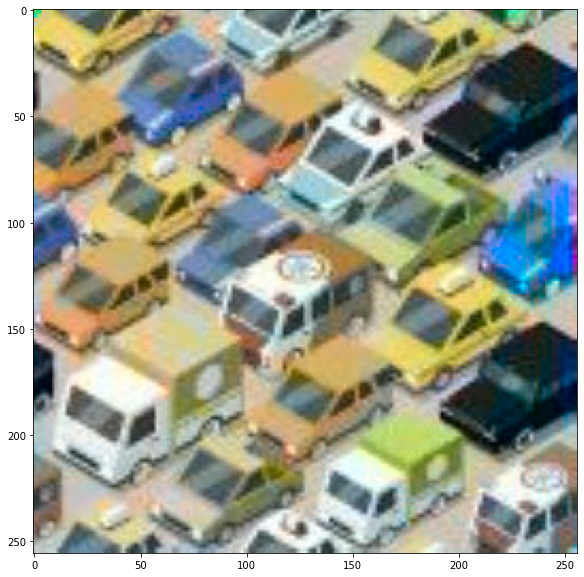

In [131]:
get_photo(image_pathway)